# Retrieve sonar data

In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from echogram import EchoGram

### Datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

### Channel (sonar sensor type)
- 0 = Primary (Traditional Sonar)
- 1 = Secondary (Traditional Sonar)
- 2 = DSI (Downscan Imaging)
- 3 = Sidescan Left
- 4 = Sidescan Right
- 5 = Sidescan (Composite)
Another other value is treated as Invalid.

In [2]:
import os
files = os.listdir('log-data-lowrance/02_20_22')
print(files)

['Sonar_2022-01-20_16.16.03.sl2', 'Sonar_2022-01-20_10.45.23.sl2', 'Sonar_2022-01-20_09.53.33.sl2', 'Sonar_2022-01-20_15.54.19.sl2', 'Sonar_2022-01-20_11.05.09.sl2']


In [3]:
with open('processed_data/dataset_012022.txt', 'rb') as fl:
    dataset_012022 = pickle.load(fl)
with open('processed_data/cropped_dataset.txt', 'rb') as fl:
    cropped_dataset = pickle.load(fl)

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

In [4]:
#echogram6mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])
with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
    # Call load method to deserialze
    echogram6mph = pickle.load(file)

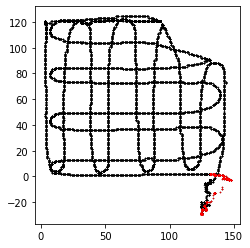

In [5]:
echogram6mph.see_range([-800, -1])

In [6]:
echogram6mph.crop_data(0,2200)
echogram6mph.crop_data(-1, -800, -1) # start from -1 to delete the last element 

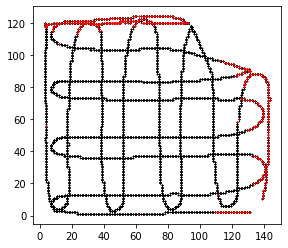

In [7]:
fig, ax = plt.subplots()
ax.plot(echogram6mph.X, echogram6mph.Y, 'ko', ms=0.5)
ax.plot(echogram6mph.X[echogram6mph.df['water_depth_m']< 0.00001], echogram6mph.Y[echogram6mph.df['water_depth_m']< 0.00001], 'ro', ms=0.5)
ax.set_aspect('equal')

echogram6mph.crop_data(None, None, step=None, use_conditional=True, condition=echogram6mph.df['water_depth_m']< 0.00001)

length:  17675


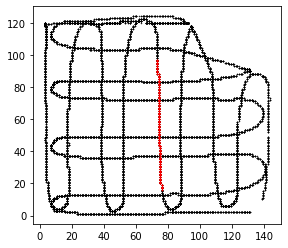

In [8]:
image_start = 3200 #3500
image_end = 3800 #4100
df2 = echogram6mph.df
print("length: ",len(df2['longitude']))
echogram6mph.see_range([image_start,image_end])

In [9]:
def lat_lon_to_meters(lon, lat):
        """ Convert longitude and latitude to global X and Y coordinates in meters
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        X = X - X[0]
        Y = Y - Y[0]
        return X, Y
    
def get_distance(x,y):
    """calculates the euclidean distance for a sequence of points in the x and y coordinate
    """
    dx = np.diff(x)
    dy = np.diff(y)
    return np.add.accumulate(np.sqrt(dx**2 + dy**2))

X, Y = lat_lon_to_meters(df2["longitude"].to_numpy(), df2["latitude"].to_numpy())
df2["X_m"] = X
df2["Y_m"] = Y
distance = get_distance(X, Y)
distance = np.append(distance, distance[-1])
df2["distance_m"] = distance

In [10]:
for ii in range(len(files)):
    #cropped_dataset[files[ii]]
    distance = get_distance(cropped_dataset[files[ii]].df["X_m"], cropped_dataset[files[ii]].df["Y_m"])
    distance = np.append(distance, distance[-1])
    cropped_dataset[files[ii]].df["distance_m"] = distance

# **Point Cloud Generation**

## Scale intensity values using min max normalization and visualize

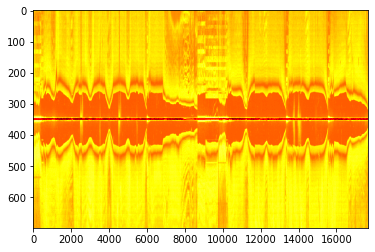

In [11]:
plt.imshow(echogram6mph.echo, cmap='hot',aspect='auto')

#### Visualize the sonar image

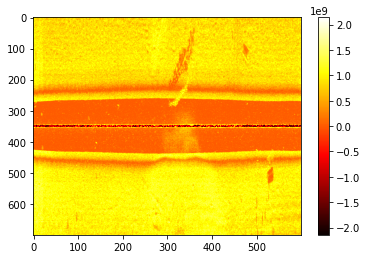

In [12]:
plt.imshow(echogram6mph.echo[:,image_start:image_end], cmap='hot',aspect='auto')
plt.colorbar()

In [13]:
for ii in range(len(files)):
    print("min: ",np.min(cropped_dataset[files[ii]].echo), end = ', ')
    print("max: ",np.max(cropped_dataset[files[ii]].echo))
print("min: ",np.min(echogram6mph.echo), end = ', ')
print("max: ",np.max(echogram6mph.echo))

min:  -2142603100.0, max:  2141233300.0
min:  -2141758100.0, max:  2141233300.0
min:  -2142805600.0, max:  2141233300.0
min:  -2141821800.0, max:  2141233300.0
min:  -2142998900.0, max:  2141233300.0
min:  -2142878100.0, max:  2141233300.0


sss shape:  (700, 17675)
min intensity= -2142878100.0
max intensity= 2141233300.0


Text(0.5, 0, 'Data points')

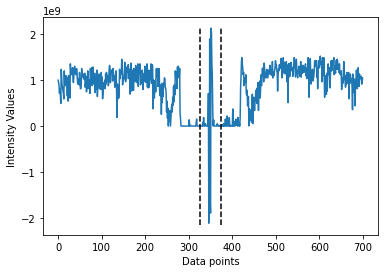

In [14]:
sss_intensity_raw = echogram6mph.echo
rows, columns = sss_intensity_raw.shape  
print("sss shape: ", sss_intensity_raw.shape)

vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
print("min intensity=",vmin)
print("max intensity=",vmax)

middle_left = 326
middle_right = 374
fig, ax = plt.subplots()
ax.plot(range(rows),sss_intensity_raw[:,image_start+1000])  # single strip of data
ax.plot(np.array([middle_right]*2),[vmin,vmax], '--k', label='range')
ax.plot(np.array([middle_left]*2),[vmin,vmax], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

In [15]:
# Delete return on the middle of sss image
sss_intensity_raw[middle_left:middle_right, :] = 0
print("min intensity=",np.min(sss_intensity_raw))
print("max intensity=",np.max(sss_intensity_raw))

min intensity= 0.0
max intensity= 2021621600.0


Text(0.5, 0, 'Data points')

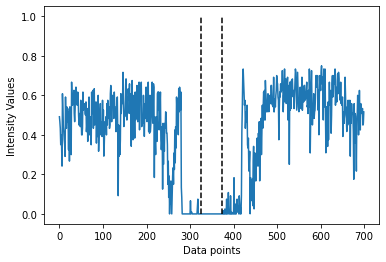

In [16]:
#sss = plt.imread('./images/sss.png') # image file, ndarray, with shape: (288, 432, 4)
vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
sss_intensity_raw = (sss_intensity_raw - vmin) / (vmax - vmin) 
#sss_intensity_raw = (sss_intensity_raw + vmax) / (2*vmax)  #symmetric scaling

sss_intensity_raw[middle_left:middle_right, :] = 0
fig, ax = plt.subplots()
ax.plot(range(rows),sss_intensity_raw[:,image_start+1000])  # single strip of data
ax.plot(np.array([middle_right]*2),[0,1], '--k', label='range')
ax.plot(np.array([middle_left]*2),[0,1], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

In [17]:
for ii in range(len(files)):
    cropped_dataset[files[ii]].echo[middle_left:middle_right, :] = 0
    vmin = np.min(cropped_dataset[files[ii]].echo)
    vmax = np.max(cropped_dataset[files[ii]].echo)
    print("min intensity=",vmin)
    cropped_dataset[files[ii]].echo = (cropped_dataset[files[ii]].echo - vmin) / (vmax - vmin)

min intensity= 0.0
min intensity= 0.0
min intensity= 0.0
min intensity= 0.0
min intensity= 0.0


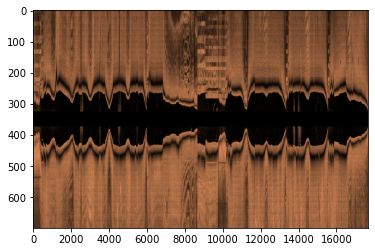

In [18]:
plt.imshow(sss_intensity_raw, cmap='copper',aspect='auto')

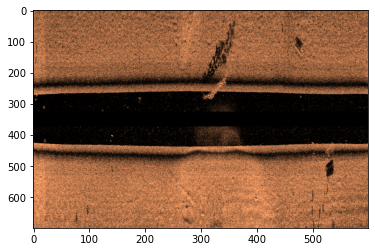

In [19]:
sss_intensity = sss_intensity_raw[:, image_start:image_end]
rows, columns = sss_intensity.shape  
plt.imshow(sss_intensity, cmap='copper',aspect='auto')

### Angles:

<div>
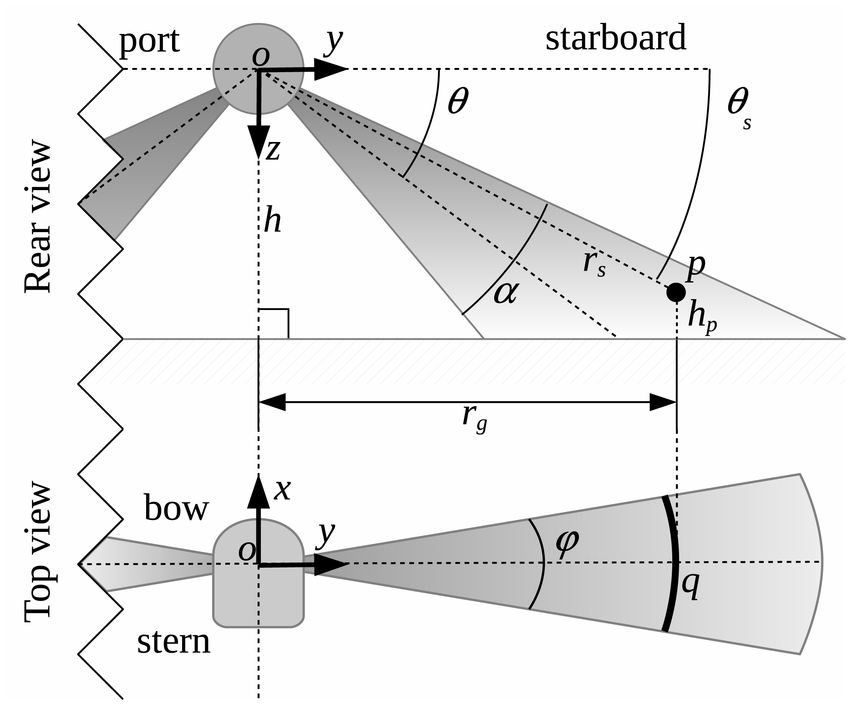
</div>

In [20]:
# Fixed Coordinate system: x - front, y - right, z - down 
alpha = 58 # from lowrance
theta = 45
theta_max = theta + alpha/2
theta_min = theta - alpha/2

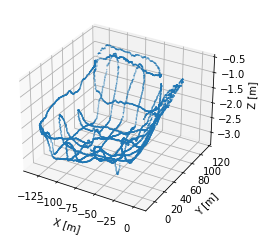

In [21]:
## Plot the point cloud
#plt.scatter(x,y,color=Z)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df2["X_m"],df2["Y_m"],-df2['water_depth_m'], s=0.1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

In [22]:
pc = pd.DataFrame({'x': df2["X_m"], 'y': df2["Y_m"], 'z': -df2['water_depth_m']})

print("Checking the PC variable exists. First element: ", pc['x'].to_numpy()[0])
with open('processed_data/PC.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc, file)

Checking the PC variable exists. First element:  0.0


Text(0, 0.5, 'Z (depth) [m]')

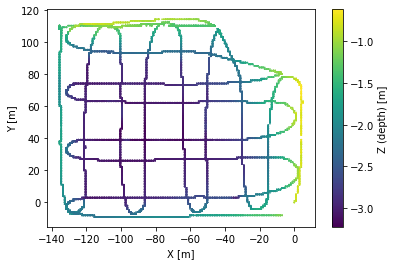

In [23]:
plt.scatter(df2["X_m"],df2["Y_m"], c=-df2['water_depth_m'], s=0.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z (depth) [m]')

Text(0.5, 0, 'Data points')

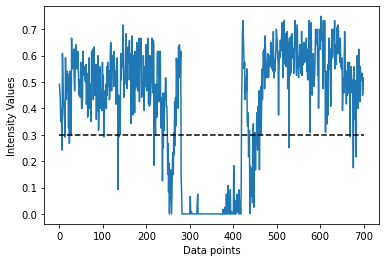

In [24]:
threshold = 0.3

fig, ax = plt.subplots()
ax.plot(range(700),sss_intensity_raw[:,image_start+1000])
ax.plot([0,700], np.array([threshold]*2), '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

In [39]:
def find_first_return_and_plot(sss_intensity, threshold, marker_size=0.5):
    """ Starts in the middle of the image, checks every pixel if it is higher than the threshold, and if it
        is, it records the index. 
        Inputs: 
            sss_intensity - sonar image of type 2d ndarray
            marker_size - used in plotting
    """
    stop = sss_intensity.shape[1]
    first_return = pd.DataFrame({'l':np.zeros(stop), 'r':np.zeros(stop)}, index =range(stop))
    kk = 0
    iir = 0
    iil = 0
    for jj in range(stop):
        iir = 0 if np.isnan(iir) else np.max([iir - 100, 0])
        iil = 0 if np.isnan(iil)  else np.max([iil - 100, 0])
        rigth_intensity = 0
        left_intensity = 0
        while (rigth_intensity < threshold or left_intensity < threshold): 
            if iil > 200 or iir > 200 or np.isnan(iir) or np.isnan(iil):
                # limit on how far in the image the algo travels
                iir = 200
                iil = 200
                break
            if rigth_intensity < threshold:
                rigth_intensity = sss_intensity[350+iir, jj]
                iir += 5
            if left_intensity < threshold:
                left_intensity = sss_intensity[350-iil, jj]
                iil += 5
        first_return.loc[kk] = [iir, iil]
        kk += 1
        if kk % 1000 == 0: print(kk,end = ',')

    plt.figure()
    plt.imshow(sss_intensity, cmap='gray', aspect='auto')
    #plt.colorbar()
    plt.plot(np.arange(stop), 350-first_return['l'].to_numpy(dtype='int'), 'ob', ms=marker_size)
    plt.plot(np.arange(stop), 350+first_return['r'].to_numpy(dtype='int'), 'or', ms=marker_size)

    #print(first_return)
    return first_return

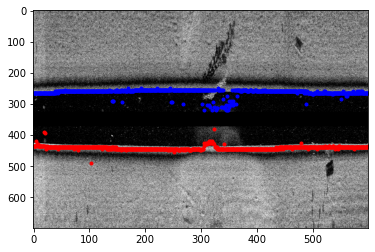

In [40]:
first_return = find_first_return_and_plot(sss_intensity, threshold=threshold, marker_size=3)

In [58]:
sind = lambda degrees: np.sin(np.deg2rad(degrees))
cosd = lambda degrees: np.cos(np.deg2rad(degrees))

flat_index = 45 #placeholder

print('theta max: ', theta_max)

def generate_sparse_PC(sss_intensity, df, first_return, flat_index, theta_max, is_print=False, use_pixel_per_dist=False, pd='None'):
    if use_pixel_per_dist:
        dist_per_pixel = pd
    else:
        pixel = first_return.loc[flat_index][0]
        water_depth = df["water_depth_m"].to_numpy()[flat_index]
        dist_per_pixel = water_depth/pixel
    print('Distance per pixel: ', dist_per_pixel)
        
    distance_r = first_return['r'].to_numpy()*dist_per_pixel
    depth_first_return_r = distance_r*sind(theta_max)
    y_first_return_r = distance_r*cosd(theta_max)

    distance_l = first_return['l'].to_numpy()*dist_per_pixel  
    depth_first_return_l = distance_l*sind(theta_max)
    y_first_return_l = distance_l*cosd(theta_max)
    
    distance = np.array([first_return['l'].to_numpy()*dist_per_pixel, first_return['r'].to_numpy()*dist_per_pixel])
    depth_first_return = distance*sind(theta_max)
    y_first_return = distance*cosd(theta_max)
    print('distance shape: ', distance.shape)
    print('y_first_return shape: ', y_first_return.shape)
    

    print('depth: ', depth_first_return_r[500] - df["water_depth_m"].to_numpy()[500]) # random depth
    print('max side dist: ', np.max(y_first_return_r))
    print('median side dist: ', np.median(y_first_return_r))
    print('mean side dist: ', np.mean(y_first_return_r))
    print('min side dist: ', np.min(y_first_return_r))
    
    print('df size: ', df["X_m"].size)
    print('df shape: ', df["X_m"].to_numpy().shape)    
    heading_vec = np.transpose([df["X_m"].to_numpy()[1:] - df["X_m"].to_numpy()[0:-1], df["Y_m"].to_numpy()[1:] - df["Y_m"].to_numpy()[0:-1], [0]*(df["Y_m"].size-1)])
    heading_vec = np.vstack((heading_vec, heading_vec[-1,:]))
    perpendicular_vec_r = np.cross(heading_vec, np.tile(np.array([0,0,1]),(heading_vec.shape[0],1)) )  # vector to right
    perpendicular_vec_l = np.cross(heading_vec, np.tile(np.array([0,0,-1]),(heading_vec.shape[0],1)) )  # vector to left
    perpendicular_vec = np.array([perpendicular_vec_l, perpendicular_vec_r])
    print('Big perpend shape: ',perpendicular_vec.shape)
    print('perpend shape: ',perpendicular_vec_r.shape)

    
    norm_r = np.linalg.norm(perpendicular_vec_r, axis=1)
    norm_r[norm_r == 0] = np.nan
    norm_l = np.linalg.norm(perpendicular_vec_l, axis=1)
    norm_l[norm_l == 0] = np.nan
    norm = np.linalg.norm(perpendicular_vec, axis=2)
    norm[norm == 0] = np.nan
    print('Big norm shape: ',norm.shape)

    
    print('norm shape: ',norm_r.shape)
    perpendicular_vec_r = np.transpose(np.transpose(perpendicular_vec_r) / norm_r)
    perpendicular_vec_l = np.transpose(np.transpose(perpendicular_vec_l) / norm_l)
    perpendicular_vec = np.transpose(np.transpose(perpendicular_vec) / norm)
    print('perpend shape: ',perpendicular_vec_r.shape)

    print('number of nans in norm: ', np.sum(np.isnan(norm_r)))
    
    X_new_r = df["X_m"].to_numpy() + perpendicular_vec_r[:,0]*y_first_return_r  
    Y_new_r = df["Y_m"].to_numpy() + perpendicular_vec_r[:,1]*y_first_return_r  
    X_new_l = df["X_m"].to_numpy() + perpendicular_vec_l[:,0]*y_first_return_l  
    Y_new_l = df["Y_m"].to_numpy() + perpendicular_vec_l[:,1]*y_first_return_l  
    X_new = df["X_m"].to_numpy() + perpendicular_vec[:,0]*y_first_return  

    print('xnew shape: ', X_new_r.shape)
    print('fraction of good data in X_new: ', (X_new_r.shape[0] - np.sum(np.isnan(X_new_r)) )/X_new_r.shape[0])
        
    if is_print:
        #debug
        sta = 100
        sto = 200
        scale = 60
        fig, ax = plt.subplots(figsize = (12, 7))
        ax.quiver(df["X_m"].to_numpy()[sta:sto], df["Y_m"].to_numpy()[sta:sto], perpendicular_vec_r[:,0][sta:sto], perpendicular_vec_r[:,1][sta:sto], scale=scale, color='r')
        ax.quiver(df["X_m"].to_numpy()[sta:sto], df["Y_m"].to_numpy()[sta:sto], perpendicular_vec_l[:,0][sta:sto], perpendicular_vec_l[:,1][sta:sto], scale=scale, color='b')
        ax.quiver(df["X_m"].to_numpy()[sta:sto], df["Y_m"].to_numpy()[sta:sto], heading_vec[:,0][sta:sto], heading_vec[:,1][sta:sto], scale=scale, color='k')
        ax.set_title('Perpendicular Field')
        plt.show()
        print('number of nans in small norm: ', np.sum(np.isnan(norm_r[sta:sto])))  
    
    return (X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l)

theta max:  74.0


In [59]:
df_fun = df2.iloc[image_start:image_start+sss_intensity.shape[1]]
X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l = generate_sparse_PC(sss_intensity, df_fun, first_return, flat_index, theta_max, is_print=True, use_pixel_per_dist=True, pd=0.0339774609375)

Distance per pixel:  0.0339774609375
distance shape:  (2, 600)
y_first_return shape:  (2, 600)
depth:  0.07561357126578416
max side dist:  1.311164048626303
median side dist:  0.8428911741169091
mean side dist:  0.8580319970593795
min side dist:  0.28096372470563635
df size:  600
df shape:  (600,)
Big perpend shape:  (2, 600, 3)
perpend shape:  (600, 3)
Big norm shape:  (2, 600)
norm shape:  (600,)


ValueError: operands could not be broadcast together with shapes (3,600,2) (2,600) 

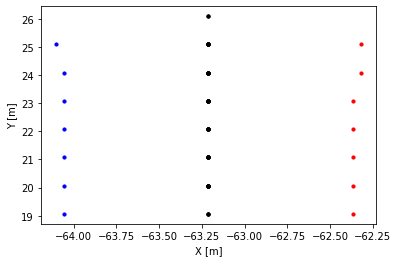

In [29]:
#debug
sta = 100
sto = 150    
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_new_r[sta:sto],Y_new_r[sta:sto], s=10, c='r')
ax.scatter(X_new_l[sta:sto], Y_new_l[sta:sto], s=10, c='b')
ax.scatter(df_fun["X_m"].to_numpy()[sta:sto],df_fun["Y_m"].to_numpy()[sta:sto], s=10, c='k')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.show()


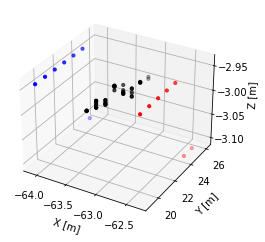

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_new_r[sta:sto],Y_new_r[sta:sto],-depth_first_return_r[sta:sto], s=10, c='r')
ax.scatter(X_new_l[sta:sto], Y_new_l[sta:sto],-depth_first_return_l[sta:sto], s=10, c='b')
ax.scatter(df_fun["X_m"].to_numpy()[sta:sto],df_fun["Y_m"].to_numpy()[sta:sto],-df_fun['water_depth_m'].to_numpy()[sta:sto], s=10, c='k')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

In [31]:
# fraction of how many right have similar depth of lefts
np.sum(depth_first_return_r == depth_first_return_l)/depth_first_return_r.shape[0]

0.51

1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,

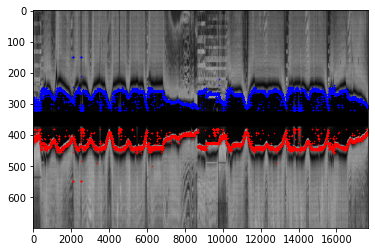

In [32]:
threshold = 0.3
first_return_complete = find_first_return_and_plot(sss_intensity_raw, threshold=threshold, marker_size=0.5)

In [33]:
first_return_complete.describe()

,l,r
count,17675.000000,17675.000000
mean,75.359547,77.250071
std,18.585078,18.062113
min,30.000000,30.000000
25%,60.000000,65.000000
50%,80.000000,80.000000
75%,90.000000,90.000000
max,200.000000,200.000000


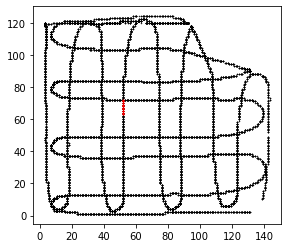

In [34]:
# Find index of a flat portion using the depthmap
echogram6mph.see_range([4430, 4500])
# well use the beginign
flat_index = 4430

In [35]:
print('theta max: ', theta_max)
X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l = generate_sparse_PC(sss_intensity_raw, df2, first_return_complete, flat_index=flat_index, theta_max=theta_max, is_print=False)

theta max:  74.0
Distance per pixel:  0.033953450775146485
distance shape:  (2, 17675)
depth:  1.2669413939522363
max side dist:  1.8717678785048035
median side dist:  0.7487071514019215
mean side dist:  0.72297100494231
min side dist:  0.2807651817757206
df size:  17675
norm shape:  (17675,)
perpend shape:  (17675, 3)
number of nans in norm:  15322
xnew shape:  (17675,)
fraction of good data in X_new:  0.13312588401697312


In [36]:
pc_r = pd.DataFrame({'x': X_new_r, 'y':  Y_new_r,'z': -depth_first_return_r})
print("Checking the PC_r variable exists. First element: ", pc_r['x'].to_numpy()[0])
with open('processed_data/PC_r.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc_r, file)
    
pc_l = pd.DataFrame({'x': X_new_l, 'y':  Y_new_l,'z': -depth_first_return_l})
print("Checking the PC_l variable exists. First element: ", pc_l['x'].to_numpy()[0])
with open('processed_data/PC_l.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc_l, file)

Checking the PC_r variable exists. First element:  nan
Checking the PC_l variable exists. First element:  nan


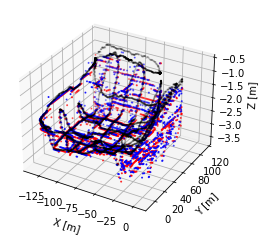

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_new_r, Y_new_r, -depth_first_return_r, s=1, c='r')
ax.scatter(X_new_l, Y_new_l, -depth_first_return_l, s=1, c='b')
ax.scatter(df2["X_m"].to_numpy(),df2["Y_m"].to_numpy(),-df2['water_depth_m'].to_numpy(), s=1, c='k', alpha=0.05)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,Distance per pixel:  0.0339774609375
distance shape:  (2, 12688)
depth:  1.074251037934296
max side dist:  1.8730914980375757
median side dist:  0.7960638866659696
mean side dist:  0.7831981927777307
min side dist:  0.28096372470563635
df size:  12688
norm shape:  (12688,)
perpend shape:  (12688, 3)
number of nans in norm:  11400
xnew shape:  (12688,)
fraction of good data in X_new:  0.10151324085750316
1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,Distance per pixel:  0.0339774609375
distance shape:  (2, 10149)
depth:  1.9380426907753492
max side dist:  1.8730914980375757
median side dist:  0.7960638866659696
mean side dist:  0.7606700427368973
min side dist:  0.28096372470563635
df size:  10149
norm shape:  (10149,)
perpend shape:  (10149, 3)
number of nans in norm:  9202
xnew shape:  (10149,)
fraction of good data in X_new:  0.09330968568331856
1000,2000,3000,4000,Distance per pixel:  0.0339774609375
distance shape:

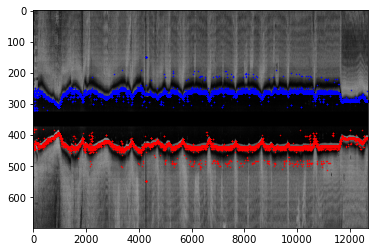

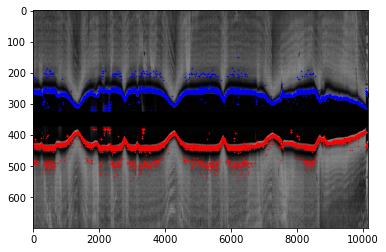

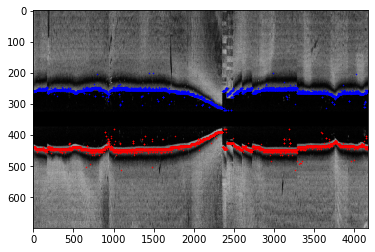

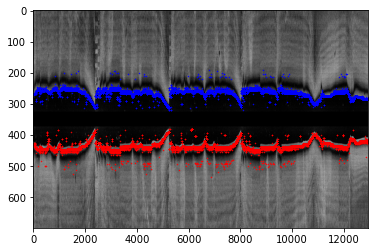

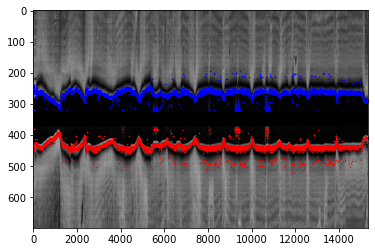

In [43]:
PC_dataset = {}

for ii in range(len(files)):
    #cropped_dataset[files[ii]].echo
    stop = cropped_dataset[files[ii]].echo.shape[1]-1
    first_return_set = find_first_return_and_plot(cropped_dataset[files[ii]].echo, threshold, 0.5)
    X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l = generate_sparse_PC(cropped_dataset[files[ii]].echo, cropped_dataset[files[ii]].df, first_return_set, flat_index=1000, theta_max=theta_max, is_print=False, use_pixel_per_dist=True, pd=0.0339774609375)
    PC_dataset[files[ii]] = pd.DataFrame(data={'x': X_new_r, 'y':  Y_new_r,'z': -depth_first_return_r})
    
print("Checking the PC_dataset variable exists. First element: ", PC_dataset[files[0]]['x'].to_numpy()[0])
with open('processed_data/PC_dataset.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(PC_dataset, file)

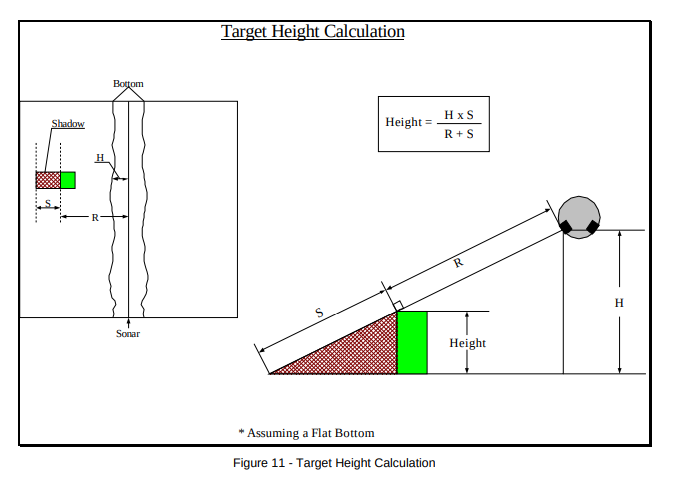
